In [1]:
# Step 1: Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum
from geopy.distance import geodesic

In [2]:
# Load the location data
locations_df = pd.read_csv("Data/locations.csv")  # Replace with the path to your 'locations.csv'

# Define demand and vehicle capacity
demands = pd.to_numeric(locations_df['demand'], errors='coerce').fillna(0).astype(int).values
vehicle_capacity = 100  # Vehicle capacity, adjust as needed

In [3]:
# Create a distance matrix based on latitude and longitude
def create_distance_matrix(locations_df):
    num_locations = len(locations_df)
    distance_matrix = np.zeros((num_locations, num_locations))
    for i in range(num_locations):
        for j in range(num_locations):
            if i != j:
                loc1 = (locations_df.iloc[i]['latitude'], locations_df.iloc[i]['longitude'])
                loc2 = (locations_df.iloc[j]['latitude'], locations_df.iloc[j]['longitude'])
                distance_matrix[i][j] = geodesic(loc1, loc2).kilometers
    return distance_matrix

# Create the distance matrix
distance_matrix = create_distance_matrix(locations_df)

In [4]:
def solve_vrp(num_locations, max_vehicles, demands, vehicle_capacity, distance_matrix, depot=0):
    # Create the Gurobi model
    model = Model()

    # Decision variables
    x = model.addVars(num_locations, num_locations, max_vehicles, vtype=GRB.BINARY, name="x")
    u = model.addVars(num_locations, max_vehicles, lb=0, ub=num_locations, vtype=GRB.CONTINUOUS, name="u")
    y = model.addVars(max_vehicles, vtype=GRB.BINARY, name="y")

    # Objective: Minimize the number of vehicles used + total distance
    model.setObjective(
        quicksum(y[k] for k in range(max_vehicles)) + 
        0.001 * quicksum(x[i, j, k] * distance_matrix[i][j] for i in range(num_locations) for j in range(num_locations) for k in range(max_vehicles)),
        GRB.MINIMIZE
    )

    # Add constraints
    add_constraints(model, x, u, y, num_locations, max_vehicles, demands, vehicle_capacity, depot)

    # Optimize the model
    model.optimize()

    if model.status == GRB.OPTIMAL:
        routes, capacity_usage = extract_routes(model, x, num_locations, max_vehicles, demands)
        save_routes_as_csv(routes, locations_df)
        plot_routes_matplotlib(routes, locations_df, capacity_usage)
    else:
        print("No optimal solution found.")

    return model

In [5]:
def add_constraints(model, x, u, y, num_locations, max_vehicles, demands, vehicle_capacity, depot):
    # 1. Flow conservation - Vehicle leaves node that it enters
    model.addConstrs(
        quicksum(x[i, j, k] for j in range(num_locations) if i != j) ==
        quicksum(x[j, i, k] for j in range(num_locations) if i != j)
        for i in range(num_locations) for k in range(max_vehicles) if i != depot
    )

    # 2. Ensure that every node is entered exactly once (except depot)
    model.addConstrs(
        quicksum(x[i, j, k] for k in range(max_vehicles) for i in range(num_locations) if i != j) == 1
        for j in range(1, num_locations)
    )

    # 3. Every vehicle leaves the depot only if it is used
    model.addConstrs(quicksum(x[depot, j, k] for j in range(1, num_locations)) == y[k] for k in range(max_vehicles))

    # 4. Every vehicle returns to the depot only if it is used
    model.addConstrs(quicksum(x[i, depot, k] for i in range(1, num_locations)) == y[k] for k in range(max_vehicles))

    # 5. MTZ subtour elimination constraints
    for k in range(max_vehicles):
        for i in range(1, num_locations):
            model.addConstr(u[i, k] >= 1)
            model.addConstr(u[i, k] <= num_locations - 1)

            for j in range(1, num_locations):
                if i != j:
                    model.addConstr(u[i, k] - u[j, k] + (num_locations) * x[i, j, k] <= num_locations - 1)

    # 6. Capacity constraint
    model.addConstrs(
        quicksum(demands[i] * quicksum(x[i, j, k] for j in range(num_locations) if i != j) for i in range(1, num_locations)) <= vehicle_capacity * y[k]
        for k in range(max_vehicles)
    )

    # 7. Ensure sequential usage of vehicles
    model.addConstrs(y[k] <= y[k-1] for k in range(1, max_vehicles))

In [6]:
def extract_routes(model, x, num_locations, max_vehicles, demands):
    routes = []
    capacity_usage = []
    for k in range(max_vehicles):
        if model.getVarByName(f"y[{k}]").X > 0.5:
            route = []
            current_location = 0
            visited_locations = {current_location}
            total_demand = 0
            print(f"\nRoute for Vehicle {k + 1}:")
            while True:
                for j in range(num_locations):
                    if x[current_location, j, k].X > 0.5 and j not in visited_locations:
                        route.append((current_location, j, k))
                        visited_locations.add(j)
                        total_demand += demands[j]
                        print(f"From {locations_df['name'].iloc[current_location]} to {locations_df['name'].iloc[j]}")
                        current_location = j
                        break
                else:
                    if x[current_location, 0, k].X > 0.5:
                        route.append((current_location, 0, k))
                        print(f"From {locations_df['name'].iloc[current_location]} back to {locations_df['name'].iloc[0]}")
                    break
                if current_location == 0:
                    break
            routes.append(route)
            capacity_percentage = (total_demand / vehicle_capacity) * 100
            capacity_usage.append((k + 1, capacity_percentage))
            print(f"Vehicle {k + 1} Capacity Usage: {capacity_percentage:.2f}%")
    return routes, capacity_usage

def save_routes_as_csv(routes, locations_df):
    route_data = []
    for vehicle_route in routes:
        for (i, j, k) in vehicle_route:
            route_data.append({
                "Vehicle": k + 1,
                "From": locations_df["name"].iloc[i],
                "To": locations_df["name"].iloc[j],
                "Latitude_From": locations_df["latitude"].iloc[i],
                "Longitude_From": locations_df["longitude"].iloc[i],
                "Latitude_To": locations_df["latitude"].iloc[j],
                "Longitude_To": locations_df["longitude"].iloc[j]
            })
    route_df = pd.DataFrame(route_data)
    route_df.to_csv("Gurobi Solver/CVRP/Vehicle_Assignment.csv", index=False)
    print("Optimal routes saved to 'Gurobi Solver/CVRP/Vehicle_Assignment.csv'.")

In [7]:
def plot_routes_matplotlib(routes, locations_df, capacity_usage):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title("Vehicle Routing Problem (Matplotlib)")
    colors = ['red', 'blue', 'green', 'purple', 'orange']

    for idx, route in enumerate(routes):
        vehicle_num, capacity_percentage = capacity_usage[idx]
        vehicle_color = colors[route[0][2] % len(colors)]
        for (i, j, k) in route:
            ax.plot([locations_df['longitude'].iloc[i], locations_df['longitude'].iloc[j]],
                    [locations_df['latitude'].iloc[i], locations_df['latitude'].iloc[j]],
                    marker='o', color=vehicle_color, label=f"Vehicle {vehicle_num} ({capacity_percentage:.2f}%)" if i == 0 else "")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys())
    plt.show()

Restricted license - for non-production use only - expires 2025-11-24
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.0.0 24A348)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1767 rows, 1842 columns and 10876 nonzeros
Model fingerprint: 0x1410959a
Variable types: 102 continuous, 1740 integer (1740 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [7e-04, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+01]
Presolve removed 193 rows and 109 columns
Presolve time: 0.06s
Presolved: 1574 rows, 1733 columns, 16581 nonzeros
Variable types: 96 continuous, 1637 integer (1637 binary)

Root relaxation: objective 2.569920e+00, 942 iterations, 0.03 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.56

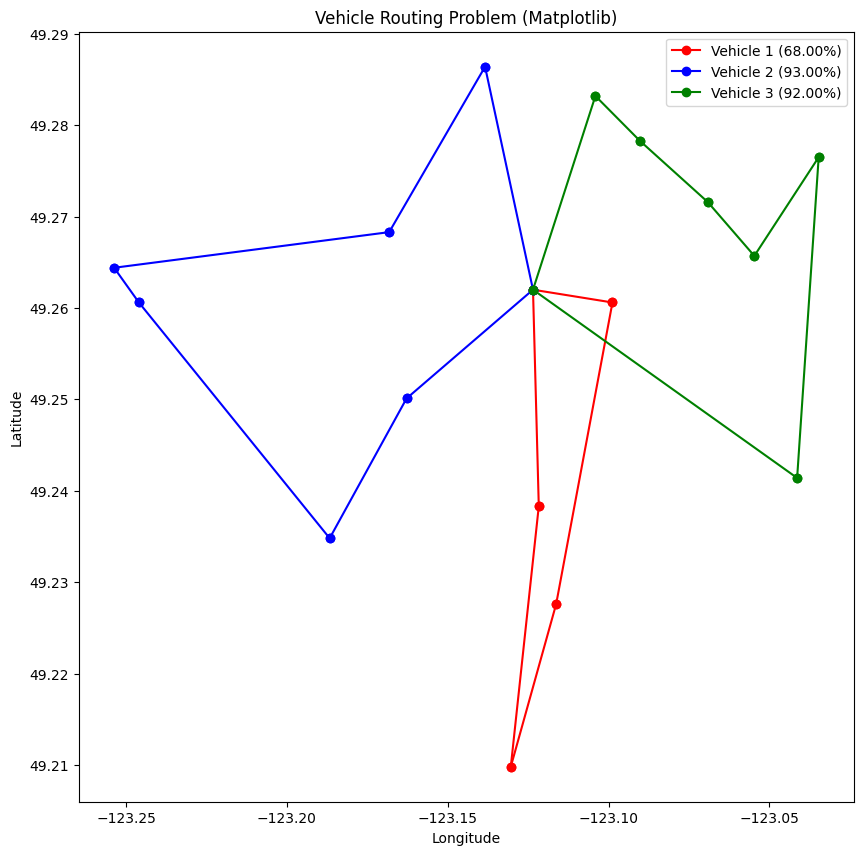

In [8]:
# Main function to run everything
def main():
    max_vehicles = 6  # Maximum vehicles allowed
    depot = 0  # First location as the depot
    solve_vrp(len(locations_df), max_vehicles, demands, vehicle_capacity, distance_matrix, depot)

# Execute the main function
if __name__ == "__main__":
    main()